In [24]:
import glob
import numpy as np
import xarray as xr
import ctd
import matplotlib.pyplot as plt
import cmocean

# Cartopy for plotting maps
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker

In [25]:
PATH = 'cruise2/ctd/proc/'

In [26]:
files = sorted(glob.glob(PATH + '*.cnv'))

In [27]:
# Map domain
extent = [-73,-70.5,40.1,40.5]

# Download ETOPO1 topography for the domain(this may take a minute)
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'
bat = xr.open_dataset(url)
bat = bat.sel(lon=slice(extent[0]-.05,extent[1]+.2),lat=slice(extent[2]-.2,extent[3]+1))

In [28]:
# get mean latitude/longitude of CTD casts
lat, lon = [],[]
for file in files:
    cast = ctd.read.from_cnv(file)
    lat.append(cast.latitude.mean()) 
    lon.append(cast.longitude.mean())

In [29]:
file

'cruise2/ctd/proc/twov0.cnv'

### Plot a quick and dirty map of station locations

/Users/crocha/miniconda3/envs/marn5995/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/crocha/miniconda3/envs/marn5995/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


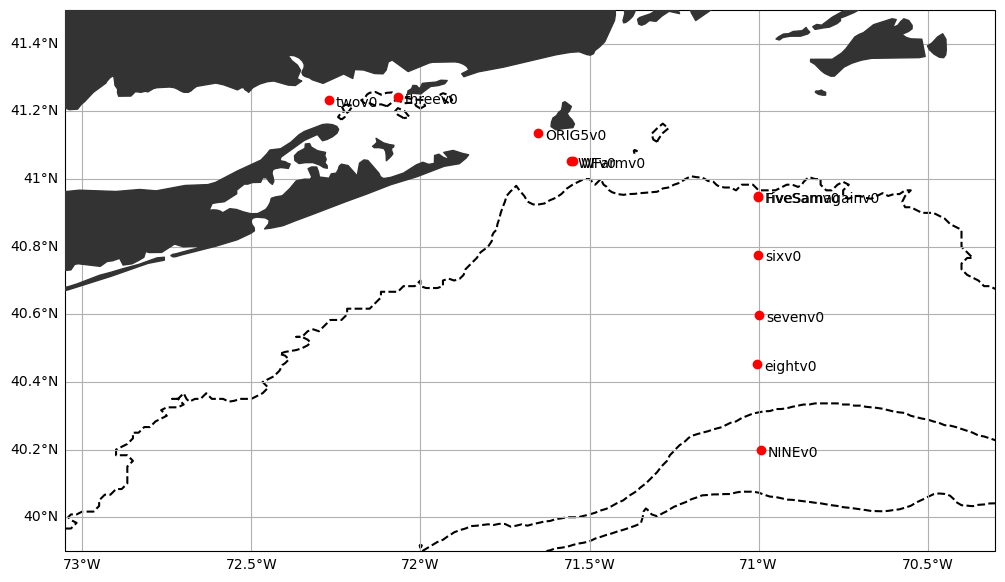

In [30]:
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(1, 1, 1, projection=projection)
# ax.set_extent(extent)

ax.scatter(lon,lat,c='r',transform=ccrs.PlateCarree(),zorder=10)

for k in range(len(files)):
    ax.text(lon[k]+.02,lat[k]-.02,files[k][17:-4])

# plot topographic contours
bat['topo'].plot.contour(
        ax=ax,levels=[-200,-100,-50],
        colors='k',
        transform=projection
)

_ = ax.add_feature(
    cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                  edgecolor='face', facecolor='0.2'),
                                  zorder=3
)

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

In [31]:
rename = {
    'sigma-t00': 'sigma0', 
    'sbeox0Mm/L': 'DO_mm_per_l', 
    'sbeox0Mg/L': 'DO_mg_per_l',
    't090C': 'temperature', 
    'sal00': 'salinity'
}

units = {
    'pressure': 'dbar',
    'sigma0': 'kg_per_m3', 
    'DO_mm_per_l': 'ml_per_l', 
    'DO_mg_per_l': 'mg_per_l',
    'temperature': 'degree_C', 
    'salinity': 'psu'
}

def simplify_cast(cast):
 
    cast = cast.rename(columns=rename)
    cast = ctd.bindata(cast,delta=.5)
    cast.index = cast.index.rename('pressure')
    cast = cast.to_xarray()
    
    return cast

def read_cast(file):
    
    cast = ctd.read.from_cnv(file)
    downcast, upcast = ctd.split(cast)
    downcast = simplify_cast(downcast)
    upcast = simplify_cast(upcast)
    return downcast, upcast

In [32]:
# load a single ctd cast
cast = ctd.read.from_cnv(files[0])
downcast, upcast = ctd.split(cast)
downcast = simplify_cast(downcast)
upcast = simplify_cast(upcast)

## Plot simple profile

(50.0, 0.0)

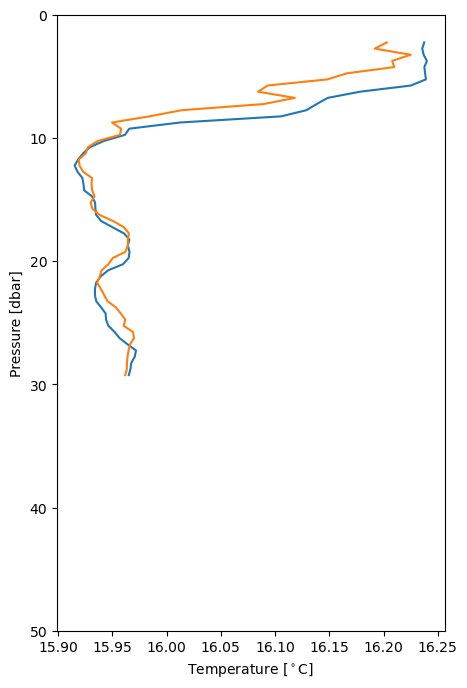

In [33]:
# simple profiles (downcast and upcast)
fig, ax = plt.subplots(figsize=(5,8))

downcast.temperature.plot(y='pressure')
upcast.temperature.plot(y='pressure')

plt.xlabel('Temperature [$^\circ$C]')
plt.ylabel('Pressure [dbar]')

plt.ylim(50,0)

In [34]:
downcast

<xarray.Dataset>
Dimensions:      (pressure: 55)
Coordinates:
  * pressure     (pressure) float64 2.25 2.75 3.25 3.75 ... 28.25 28.75 29.25
Data variables:
    sigma0       (pressure) float64 23.73 23.73 23.73 ... 24.03 24.03 24.03
    latitude     (pressure) float64 40.95 40.95 40.95 ... 40.95 40.95 40.95
    longitude    (pressure) float64 -71.0 -71.0 -71.0 ... -71.0 -71.0 -71.0
    DO_mm_per_l  (pressure) float64 272.8 272.8 273.4 ... 249.6 248.1 248.5
    DO_mg_per_l  (pressure) float64 8.729 8.731 8.75 8.734 ... 7.988 7.939 7.953
    ph           (pressure) float64 8.145 8.146 8.145 ... 8.098 8.099 8.099
    temperature  (pressure) float64 16.24 16.24 16.24 ... 15.97 15.97 15.97
    salinity     (pressure) float64 32.44 32.44 32.44 ... 32.76 32.76 32.76
    nbf          (pressure) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    prDE         (pressure) float64 3.291 3.986 4.748 ... 41.29 42.04 42.74
    flag         (pressure) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

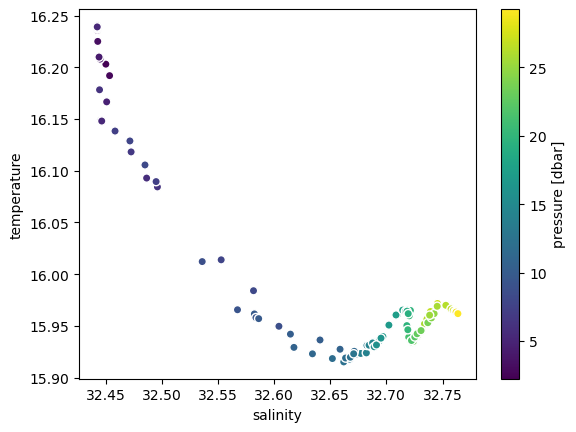

In [37]:
# property v. property diagrams
downcast.plot.scatter(y='temperature',x='salinity',c=downcast.pressure)
im = upcast.plot.scatter(y='temperature',x='salinity',c=upcast.pressure)
plt.colorbar(im,label=r'pressure [dbar]')

## All stations

In [38]:
files

['cruise2/ctd/proc/FiveSamagainv0.cnv',
 'cruise2/ctd/proc/FiveSamv0.cnv',
 'cruise2/ctd/proc/NINEv0.cnv',
 'cruise2/ctd/proc/ORIG5v0.cnv',
 'cruise2/ctd/proc/WFarmv0.cnv',
 'cruise2/ctd/proc/WFv0.cnv',
 'cruise2/ctd/proc/eightv0.cnv',
 'cruise2/ctd/proc/sevenv0.cnv',
 'cruise2/ctd/proc/sixv0.cnv',
 'cruise2/ctd/proc/threev0.cnv',
 'cruise2/ctd/proc/twov0.cnv']

In [ ]:
# merging a few station to plot a section
station_names = ['FiveSamv0', 'sixv0', 'sevenv0','eightv0','NINEv0']
casts = [5,6,7,8,9]

fni = PATH + station_names[0] + '.cnv'

# read downcast profiles and put them into an xarray dataset
for name,cast in zip(station_names,casts):
    
    dfoo, _ = read_cast(PATH + name + '.cnv')
    dfoo['cast'] = cast
    dfoo['latitude'] = dfoo.latitude.mean()
    dfoo['longitude'] = dfoo.longitude.mean()
    dfoo = dfoo.expand_dims('cast').set_coords(['cast','latitude','longitude'])
    
    if name == station_names[0]:
        ctdsection = dfoo
    else:
        ctdsection = xr.merge([ctdsection,dfoo])

### A temperature section

In [ ]:
# simple section with pcolor
ctdsection.temperature.plot(x='latitude',cmap='viridis')
plt.ylim(120,0)

In [44]:
# an alternative section with scatter plot

## Your turn: plot other properties 
Plot property-property diagrams and section for other variables of your choise. Interpret the results.